In [1]:
from utils import *
from sklearn.datasets import make_friedman3
from multiprocessing import Pool
from scipy import optimize

# Friedman 3 Data

## Dataset

In [2]:
# add noise
# redo with scipy.minimize
X, y = make_friedman3(random_state=18397425)
datasets = processing(X, y)

X, y = datasets['orig']
X_norm, y_norm = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_train_norm, y_train_norm, y_train_norm_noisy = datasets['norm train']

## Noiseless

### $\mathbb{R}^d$

In [3]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)


lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds=(1e-9, 1e5) 
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X)

NTK     :  0.0065**2 * NTK(depth=3, c=2.000, bias=0.000)
NTK     :  0.000422**2 * NTK(depth=100, c=2.000, bias=0.002)
Laplace :  1**2 * Matern(length_scale=1, nu=0.5)


In [4]:
# def f(args):
#     ell, gp, X, X_train, y_train, residual_target, out = args
#     gp.set_params(**{'kernel__k2__length_scale': ell})
#     gp.fit(X_train, y_train)

#     if out:
#         print(gp)
        
#     mean = gp.predict(X)
#     return np.corrcoef((residual_target)[:,0], (y-mean)[:,0])[0, 1]

In [5]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [6]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_2 = p.map(f, args)
#     i = np.argmax(result_2)
#     print(f"NTK depth 100, LPK lengthscale {ell_search[i]} at {i} with {max(result_2)}")

In [7]:
def g(ell, residual):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train, y_train)
    mean = gp_lpk.predict(X)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [8]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1), method='bounded', bounds=[0.0001, 1000000], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1         381966    -0.839021        initial
    2         618034    -0.839026        golden
    3         763932    -0.839027        golden
    4         882034    -0.839028        parabolic
    5         836923    -0.839028        golden
    6         927093    -0.839028        golden
    7         954941    -0.839029        golden
    8         972152    -0.839029        golden
    9         982789    -0.839029        golden
   10         989363    -0.839029        golden
   11         993426    -0.839029        golden
   12         995937    -0.839029        golden
   13         997489    -0.839029        golden
   14         998448    -0.839029        golden
   15         999041    -0.839029        golden
   16         999407    -0.839029        golden
   17         999634    -0.839029        golden
   18         999774    -0.839029        golden
   19         999860    -0.839029        golden
   20         999914    -0.8390

     fun: -0.839028847653523
 message: 'Solution found.'
    nfev: 36
     nit: 36
  status: 0
 success: True
       x: 999999.3247611022

In [9]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2), method='bounded', bounds=[0.0001, 1000000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1         381966    -0.830706        initial
    2         618034    -0.830711        golden
    3         763932    -0.830712        golden
    4         882046    -0.830713        parabolic
    5         836931    -0.830713        golden
    6         927101    -0.830713        golden
    7         954946    -0.830713        golden
    8         972155    -0.830713        golden
    9         982791    -0.830713        golden
   10         989364    -0.830713        golden
   11         993427    -0.830713        golden
   12         995937    -0.830713        golden
   13         997489    -0.830713        golden
   14         998448    -0.830713        golden
   15         999041    -0.830713        golden
   16         999407    -0.830713        golden
   17         999634    -0.830713        golden
   18         999774    -0.830713        golden
   19         999860    -0.830713        golden
   20         999914    -0.8307

     fun: -0.8307134709954231
 message: 'Solution found.'
    nfev: 35
     nit: 35
  status: 0
 success: True
       x: 999999.2722983421

In [10]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train, y_train)
mean_opt_1 = gp_lpk.predict(X)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train, y_train)
mean_opt_2 = gp_lpk.predict(X)

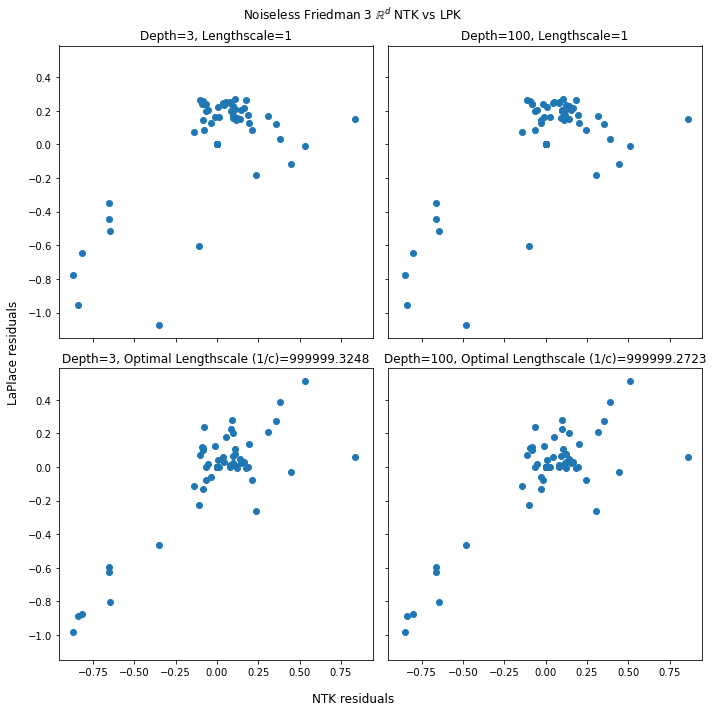

In [11]:
fig1, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax1 = ax1.ravel()
ax1[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax1[0].set_title('Depth=3, Lengthscale=1')
ax1[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax1[1].set_title('Depth=100, Lengthscale=1')
ax1[2].scatter(y - mean_ntk_1, y - mean_opt_1)
# USE LENGTHSCALE NOT PARAMETERIZATION C = 1/ELL
ax1[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax1[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax1[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig1.suptitle(r'Noiseless Friedman 3 $\mathbb{R}^d$ NTK vs LPK')
fig1.supxlabel('NTK residuals')
fig1.supylabel('LaPlace residuals')
fig1.tight_layout()

### $\mathbb{S}^{d-1}$

In [12]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds=(1e-9, 1e5) 
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X_norm)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X_norm)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train_norm, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X_norm)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  3.1**2 * NTK(depth=3, c=2.000, bias=0.676)
NTK     :  0.148**2 * NTK(depth=100, c=2.000, bias=0.000)
Laplace :  5.17**2 * Matern(length_scale=1, nu=0.5)


In [13]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [14]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [15]:
def g(ell, residual):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train_norm, y_train)
    mean = gp_lpk.predict(X_norm)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [16]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 1000], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        381.967    -0.999999        initial
    2        618.034    -0.999999        golden
    3        763.932    -0.999999        golden
    4        881.401    -0.999999        parabolic
    5        926.702    -0.999999        golden
    6        954.699    -0.999999        golden
    7        972.003    -0.999999        golden
    8        982.697    -0.999999        golden
    9        989.306    -0.999999        golden
   10        993.391    -0.999999        golden
   11        995.915    -0.999999        golden
   12        997.475    -0.999999        golden
   13         998.44    -0.999999        golden
   14        999.036    -0.999999        golden
   15        999.404    -0.999999        golden
   16        999.632    -0.999999        golden
   17        999.772    -0.999999        golden
   18        999.859    -0.999999        golden
   19        999.913    -0.999999        golden
   20        999.946    -0.9999

     fun: -0.9999986633687185
 message: 'Solution found.'
    nfev: 33
     nit: 33
  status: 0
 success: True
       x: 999.9668328363706

In [17]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 1000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        381.967    -0.995769        initial
    2        618.034    -0.995769        golden
    3        236.069    -0.995769        golden
    4        145.899    -0.995769        golden
    5        90.1709    -0.995769        golden
    6         55.729     -0.99577        golden
    7        34.4428    -0.995771        golden
    8        21.2872    -0.995772        golden
    9        13.1566    -0.995775        golden
   10        8.13161     -0.99578        golden
   11        5.02599    -0.995787        golden
   12        3.10662    -0.995802        golden
   13        1.92038    -0.995828        golden
   14        1.18724    -0.995881        golden
   15       0.734137    -0.995991        golden
   16       0.454103    -0.996225        golden
   17       0.281033    -0.996717        golden
   18        0.17407    -0.997663        golden
   19       0.107963    -0.998997        golden
   20      0.0671069    -0.999269 

     fun: -0.9994833344114356
 message: 'Solution found.'
    nfev: 30
     nit: 30
  status: 0
 success: True
       x: 0.07907329300829524

In [18]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_1 = gp_lpk.predict(X_norm)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_2 = gp_lpk.predict(X_norm)

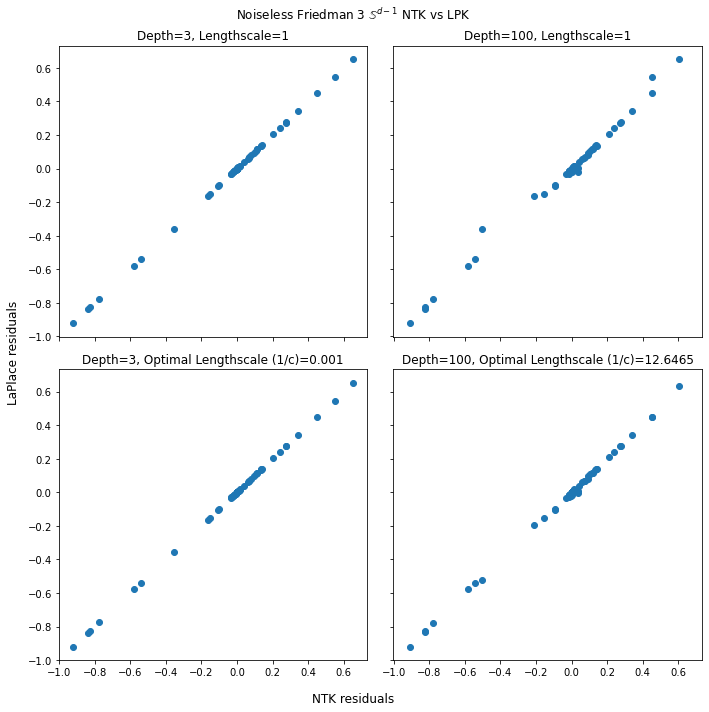

In [19]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noiseless Friedman 3 $\mathbb{S}^{d-1}$ NTK vs LPK')
fig2.supxlabel('NTK residuals')
fig2.supylabel('LaPlace residuals')
fig2.tight_layout()

### RBF

In [20]:
rbf = (
        ConstantKernel(
            constant_value=0.224**2, 
            constant_value_bounds=(1e-9, 1e5) 
        ) * 
        Matern(
            nu=np.inf,
            length_scale=1,
            length_scale_bounds='fixed',#(1e-1, 1e3), 
        ) 
    )

gp_rbf = GPR(kernel=rbf, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_rbf.fit(X_train_norm, y_train)
mean_rbf = gp_rbf.predict(X_norm)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [21]:
def h(ell, residual):
    gp_rbf.set_params(**{'kernel__k2__length_scale': ell})
    gp_rbf.fit(X_train_norm, y_train)
    mean = gp_rbf.predict(X_norm)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [22]:
ell_3 = optimize.minimize_scalar(h, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 10000], options={'disp':3})
ell_3

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calli

 
 Func-count     x          f(x)          Procedure
    1        3819.66    -0.779671        initial
    2        6180.34     -0.78203        golden
    3        7639.32    -0.781891        golden
    4        6743.56    -0.774675        parabolic
    5        5278.64    -0.778813        golden
    6        5835.92    -0.783645        golden


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warn

    7        5623.06     -0.78296        golden
    8        5842.86    -0.777246        parabolic
    9        5754.62    -0.779241        golden
   10        5804.87    -0.780907        golden
   11        5824.06     -0.77404        golden


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    htt

   12        5831.39     -0.77274        golden
   13        5838.57    -0.772919        golden
   14        5834.19    -0.782684        golden
   15        5836.93    -0.776076        golden
   16        5835.26    -0.778898        golden
   17        5836.31    -0.774901        golden
   18        5835.67    -0.776637        golden
   19        5836.07    -0.780489        golden
   20        5835.83    -0.782795        golden
   21        5835.98    -0.775517        golden


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproc

   22        5835.88    -0.775961        golden
   23        5835.94    -0.778011        golden
   24        5835.91    -0.781942        golden
   25        5835.93    -0.775142        golden
   26        5835.92    -0.776966        golden
   27        5835.92    -0.786635        golden
   28        5835.93    -0.785759        golden
   29        5835.93    -0.784903        parabolic
   30        5835.92    -0.770458        golden
   31        5835.92    -0.780832        golden
   32        5835.92    -0.782117        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproc

     fun: -0.7866345752976021
 message: 'Solution found.'
    nfev: 32
     nit: 32
  status: 0
 success: True
       x: 5835.924911806144

In [23]:
ell_100 = optimize.minimize_scalar(h, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 100000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        38196.6     -0.81114        initial
    2        61803.4    -0.817649        golden
    3        76393.2    -0.818986        golden
    4        78605.9    -0.815166        parabolic
    5        69521.8     -0.81144        parabolic
    6        73768.6    -0.819486        golden
    7          71040    -0.820794        parabolic
    8        72082.2    -0.826209        golden
    9        72333.1    -0.809105        parabolic
   10        72082.2    -0.826209        parabolic
   11        72082.2    -0.821403        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warn

     fun: -0.8262089647344375
 message: 'Solution found.'
    nfev: 11
     nit: 11
  status: 0
 success: True
       x: 72082.2242059426

In [24]:
# D=3
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_1 = gp_rbf.predict(X_norm)

# D=100
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_2 = gp_rbf.predict(X_norm)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


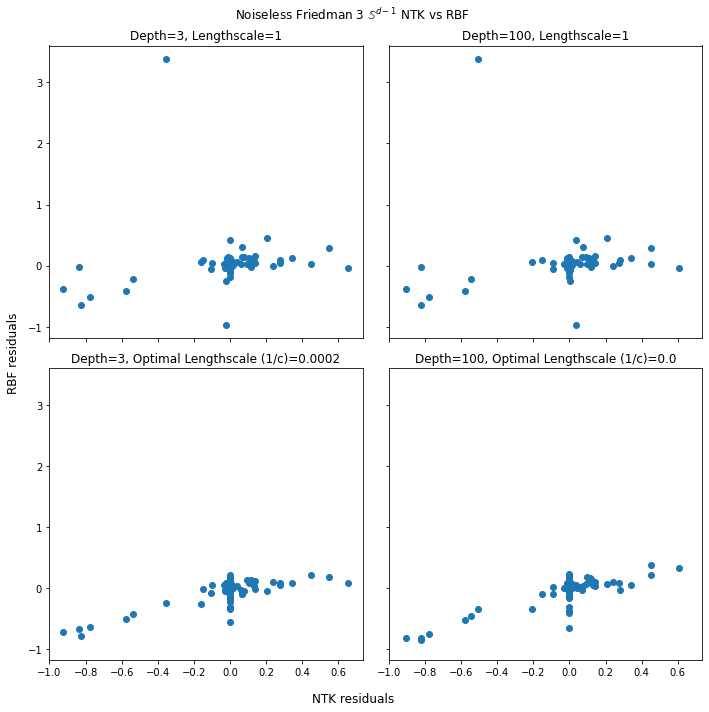

In [25]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_rbf)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_rbf)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noiseless Friedman 3 $\mathbb{S}^{d-1}$ NTK vs RBF')
fig2.supxlabel('NTK residuals')
fig2.supylabel('RBF residuals')
fig2.tight_layout()

In [26]:
# lengthscale = np.linspace(0.1, 5, 50)

# fig, ax = plt.subplots(nrows=10, ncols=5, sharex=True, sharey=True, figsize=(15, 30))
# ax=ax.ravel()

# for x, ax in zip(lengthscale, ax):
#     rbf = (
#         ConstantKernel(
#             constant_value=0.05, 
#             constant_value_bounds=(1e-9, 1e5) 
#         ) * 
#         Matern(
#             nu=np.inf,
#             length_scale=x,
#             length_scale_bounds='fixed',#(1e-1, 1e3), 
#         ) 
#     )

#     gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
#     gp.fit(X_train_norm, y_train)
#     mean_rbf = gp.predict(X_norm)

#     ax.set_title(f'RBF Lengthscale={x.round(2)}')
#     ax.scatter(y-mean_ntk_1, y-mean_rbf)

# fig.suptitle(r"NTK vs RBF Kernel in $\mathbb{S}^{d-1}$")
# fig.supxlabel('NTK residuals')
# fig.supylabel('RBF residuals')
# fig.tight_layout()

In [27]:
# rbf = (
#     ConstantKernel(
#         constant_value=0.05, 
#         constant_value_bounds=(1e-9, 1e5) 
#     ) * 
#     Matern(
#         nu=np.inf,
#         length_scale=0.35,
#         length_scale_bounds=(1e-1, 1e3), 
#     ) 
# )

# gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
# gp.fit(X_train_norm, y_train)
# mean_rbf = gp.predict(X_norm)
# print(rbf)
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.set_title(f'RBF Lengthscale={0.35}')
# ax.scatter(y-mean_ntk_1, y-mean_rbf)

In [28]:
np.corrcoef((y-mean_ntk_1)[:,0], (y-mean_rbf)[:,0])

array([[1.        , 0.10717036],
       [0.10717036, 1.        ]])

In [29]:
np.corrcoef((y-mean_ntk_1)[:,0], (y-mean_lpk)[:,0])

array([[1.       , 0.9999944],
       [0.9999944, 1.       ]])

## Dataset

In [30]:
X, y = make_friedman3(noise=0.2, random_state=18397425)
datasets = processing(X, y)

X, y = datasets['orig']
X_norm, y_norm = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_train_norm, y_train_norm, y_train_norm_noisy = datasets['norm train']

## Noisy

### $\mathbb{R}^d$

In [31]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds=(1e-9, 1e5) 
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X)

NTK     :  0.00906**2 * NTK(depth=3, c=2.000, bias=0.000)
NTK     :  0.000486**2 * NTK(depth=100, c=2.000, bias=0.004)
Laplace :  1**2 * Matern(length_scale=1, nu=0.5)


In [32]:
# def f(args):
#     ell, gp, X, X_train, y_train, residual_target, out = args
#     gp.set_params(**{'kernel__k2__length_scale': ell})
#     gp.fit(X_train, y_train)

#     if out:
#         print(gp)
        
#     mean = gp.predict(X)
#     return np.corrcoef((residual_target)[:,0], (y-mean)[:,0])[0, 1]

In [33]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [34]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_2 = p.map(f, args)
#     i = np.argmax(result_2)
#     print(f"NTK depth 100, LPK lengthscale {ell_search[i]} at {i} with {max(result_2)}")

In [35]:
def g(ell, residual):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train, y_train)
    mean = gp_lpk.predict(X)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [36]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 10000], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        3819.66    -0.811553        initial
    2        6180.34    -0.811667        golden
    3        7639.32    -0.811705        golden
    4        9072.15     -0.81173        parabolic
    5        8524.86    -0.811722        golden
    6        9426.56    -0.811736        golden
    7        9645.59    -0.811739        golden
    8        9780.97     -0.81174        golden
    9        9864.63    -0.811742        golden
   10        9916.34    -0.811742        golden
   11        9948.29    -0.811743        golden
   12        9968.04    -0.811743        golden
   13        9980.25    -0.811743        golden
   14        9987.79    -0.811743        golden
   15        9992.46    -0.811743        golden
   16        9995.34    -0.811743        golden
   17        9997.12    -0.811743        golden
   18        9998.22    -0.811743        golden
   19         9998.9    -0.811743        golden
   20        9999.32    -0.8117

     fun: -0.8117433098046424
 message: 'Solution found.'
    nfev: 37
     nit: 37
  status: 0
 success: True
       x: 9999.99984343824

In [37]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 10000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        3819.66    -0.810222        initial
    2        6180.34    -0.810357        golden
    3        7639.32    -0.810402        golden
    4        9091.63    -0.810433        parabolic
    5         8536.9    -0.810422        golden
    6         9438.6    -0.810439        golden
    7        9653.03    -0.810442        golden
    8        9785.56    -0.810444        golden
    9        9867.47    -0.810446        golden
   10        9918.09    -0.810446        golden
   11        9949.38    -0.810447        golden
   12        9968.71    -0.810447        golden
   13        9980.66    -0.810447        golden
   14        9988.05    -0.810447        golden
   15        9992.61    -0.810448        golden
   16        9995.44    -0.810448        golden
   17        9997.18    -0.810448        golden
   18        9998.26    -0.810448        golden
   19        9998.92    -0.810448        golden
   20        9999.33    -0.8104

     fun: -0.8104476156258655
 message: 'Solution found.'
    nfev: 36
     nit: 36
  status: 0
 success: True
       x: 9999.999698251486

In [38]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train, y_train)
mean_opt_1 = gp_lpk.predict(X)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train, y_train)
mean_opt_2 = gp_lpk.predict(X)

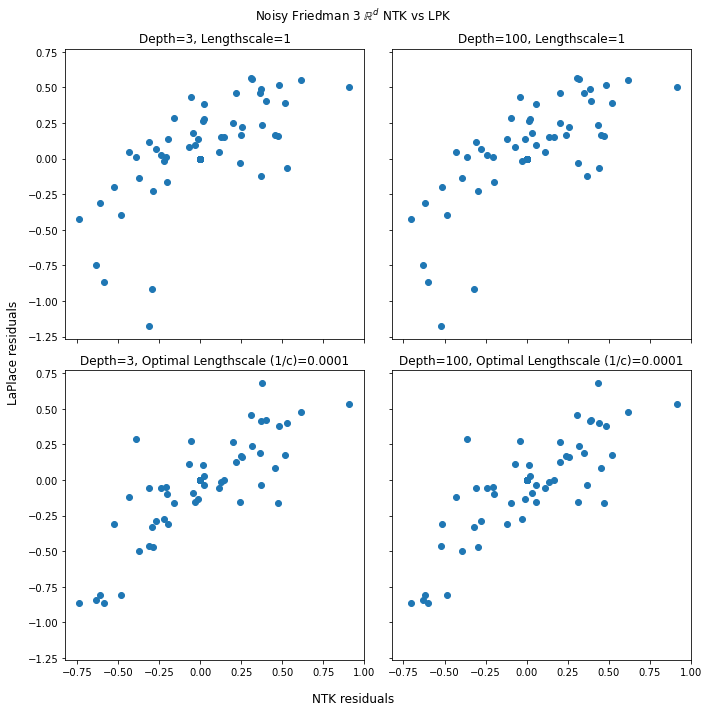

In [39]:
fig1, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax1 = ax1.ravel()
ax1[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax1[0].set_title('Depth=3, Lengthscale=1')
ax1[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax1[1].set_title('Depth=100, Lengthscale=1')
ax1[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax1[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax1[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax1[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig1.suptitle(r'Noisy Friedman 3 $\mathbb{R}^d$ NTK vs LPK')
fig1.supxlabel('NTK residuals')
fig1.supylabel('LaPlace residuals')
fig1.tight_layout()

### $\mathbb{S}^{d-1}$

In [40]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e2)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e2)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds=(1e-9, 1e5) 
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X_norm)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X_norm)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train_norm, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X_norm)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  0.239**2 * NTK(depth=3, c=2.000, bias=21.837)
NTK     :  0.023**2 * NTK(depth=100, c=2.000, bias=8.420)
Laplace :  7.19**2 * Matern(length_scale=1, nu=0.5)


In [41]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [42]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [43]:
def g(ell, residual):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train_norm, y_train)
    mean = gp_lpk.predict(X_norm)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [44]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 100000], options={'disp':3})
ell_3

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warn

 
 Func-count     x          f(x)          Procedure
    1        38196.6    -0.999999        initial
    2        61803.4    -0.999999        golden
    3        23606.8    -0.999999        golden
    4        14589.8    -0.999999        golden
    5           9017    -0.999999        golden
    6        5572.81    -0.999999        golden
    7        3444.19    -0.999999        golden
    8        2128.62    -0.999999        golden
    9        1315.56    -0.999999        golden
   10        813.063    -0.999999        golden
   11        502.501    -0.999999        golden
   12        310.563    -0.999999        golden
   13        191.939    -0.999999        golden
   14        118.625    -0.999999        golden
   15        73.3147    -0.999999        golden
   16        45.3114    -0.999999        golden
   17        28.0044    -0.999999        golden
   18         17.308    -0.999999        golden
   19        10.6973    -0.999999        golden
   20         6.6117    -0.999999 

     fun: -0.9999994179978913
 message: 'Solution found.'
    nfev: 39
     nit: 39
  status: 0
 success: True
       x: 1.6289141666650535

In [45]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 100000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        38196.6    -0.995429        initial
    2        61803.4    -0.995429        golden
    3        76393.2    -0.995429        golden


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warn

    4        85410.2    -0.995429        golden
    5          90983    -0.995429        golden
    6        83952.1    -0.995429        parabolic
    7        87371.9    -0.995429        parabolic
    8        86159.5    -0.995429        golden
    9        84853.3    -0.995429        golden
   10        85696.4    -0.995429        golden
   11        85197.5    -0.995429        golden
   12        85519.5    -0.995429        golden
   13        85328.9    -0.995429        golden
   14          85452    -0.995429        golden
   15        85379.2    -0.995429        golden
   16        85426.1    -0.995429        golden
   17        85398.3    -0.995429        golden
   18        85416.3    -0.995429        golden
   19        85405.7    -0.995429        golden
   20        85414.4    -0.995429        parabolic
   21        85408.5    -0.995429        golden
   22        85411.8    -0.995429        golden
   23        85409.5    -0.995429        golden
   24        85410.8    -0.9954

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warn

     fun: -0.9954293474166064
 message: 'Solution found.'
    nfev: 36
     nit: 36
  status: 0
 success: True
       x: 85410.19677086647

In [46]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_1 = gp_lpk.predict(X_norm)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_2 = gp_lpk.predict(X_norm)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


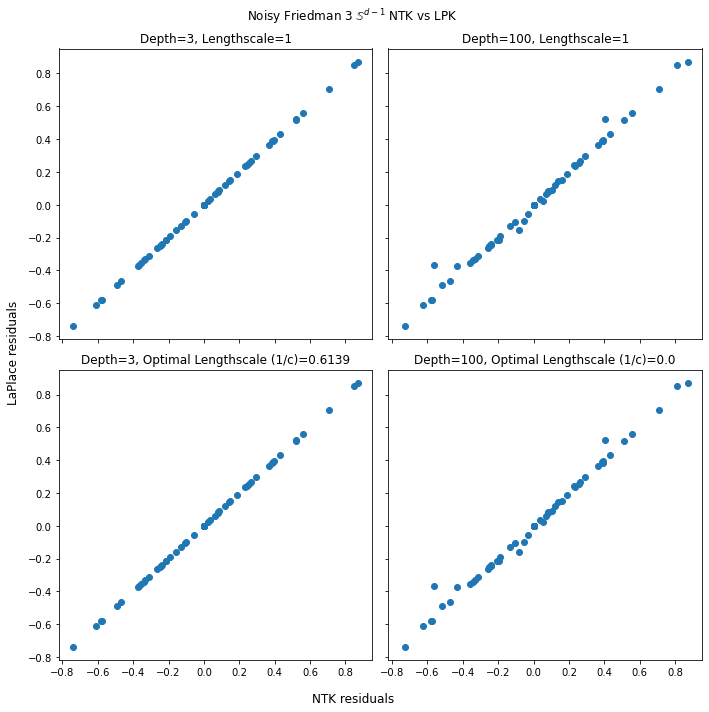

In [47]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noisy Friedman 3 $\mathbb{S}^{d-1}$ NTK vs LPK')
fig2.supxlabel('NTK residuals')
fig2.supylabel('LaPlace residuals')
fig2.tight_layout()

### RBF

In [48]:
rbf = (
        ConstantKernel(
            constant_value=0.224**2, 
            constant_value_bounds=(1e-9, 1e5) 
        ) * 
        Matern(
            nu=np.inf,
            length_scale=1,
            length_scale_bounds='fixed',#(1e-1, 1e3), 
        ) 
    )

gp_rbf = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_rbf.fit(X_train_norm, y_train)
mean_rbf = gp_rbf.predict(X_norm)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [49]:
def h(ell, residual):
    gp_rbf.set_params(**{'kernel__k2__length_scale': ell})
    gp_rbf.fit(X_train_norm, y_train)
    mean = gp_rbf.predict(X_norm)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [50]:
ell_3 = optimize.minimize_scalar(h, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 100000], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        38196.6    -0.480974        initial
    2        61803.4    -0.457993        golden
    3        23606.8    -0.523339        golden
    4        14589.8    -0.574369        golden
    5           9017    -0.607417        golden
    6        5572.81    -0.619705        golden
    7        3444.19    -0.623296        golden
    8        2008.43    -0.624205        parabolic


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calli

    9        1656.16    -0.491776        parabolic
   10        2556.84    -0.624034        golden
   11         1852.1     -0.62419        parabolic
   12         2015.1    -0.624205        parabolic
   13        1995.72    -0.624205        parabolic
   14        1940.86    -0.311047        golden
   15        2001.29    -0.624205        parabolic
   16        1974.76    -0.624205        golden
   17        1987.71    -0.624205        golden
   18        1982.77    -0.624205        golden
   19        1990.77    -0.624205        golden
   20        1985.82    -0.624205        golden
   21        1988.88    -0.624205        golden
   22        1986.99    -0.624205        golden
   23         1987.8    -0.624205        parabolic
   24        1987.71    -0.624205        parabolic
   25        1987.74    -0.624205        golden
   26        1987.72    -0.181652        golden
   27        1987.72    -0.501199        golden
   28        1987.71    -0.624205        golden
   29        1987.7

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


     fun: -0.6242051772091762
 message: 'Solution found.'
    nfev: 32
     nit: 32
  status: 0
 success: True
       x: 1987.7127761140023

In [59]:
ell_100 = optimize.minimize_scalar(h, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 100000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        38196.6    -0.507304        initial
    2        61803.4    -0.485649        golden
    3        23606.8    -0.546705        golden
    4        14589.8    -0.592704        golden
    5           9017    -0.620452        golden
    6        5572.81    -0.629359        golden
    7        2422.09    -0.632112        parabolic
    8        2315.06    -0.632162        parabolic
    9        1430.79    -0.632347        golden
   10        1475.88    -0.632356        parabolic
   11        1665.79    -0.632364        parabolic
   12        1913.79    -0.632316        golden
   13        1598.96    -0.632367        parabolic
   14        1602.37    -0.632367        parabolic
   15        1610.28    -0.632367        parabolic
   16        1603.12    -0.632367        parabolic
   17        1600.84    -0.632367        parabolic
   18        1601.79    -0.632367        golden
   19        1602.66    -0.632367        golden
   20  

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


   24        1602.34    -0.515118        golden
   25        1602.39    -0.632367        golden
   26        1602.38    -0.632367        parabolic
   27         1602.4    -0.632367        golden
   28        1602.39    -0.632367        golden
   29        1602.39    -0.632367        golden
   30        1602.39    -0.632367        golden
   31        1602.39    -0.632367        golden
   32        1602.39    -0.632367        golden
   33        1602.39    -0.632367        golden
   34        1602.39    -0.632367        golden
   35        1602.39    -0.632367        golden
   36        1602.39    -0.632367        golden
   37        1602.39    -0.632367        golden
   38        1602.39    -0.632367        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


     fun: -0.6323667298015792
 message: 'Solution found.'
    nfev: 38
     nit: 38
  status: 0
 success: True
       x: 1602.3886132835962

In [52]:
# D=3
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_1 = gp_rbf.predict(X_norm)

# D=100
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_2 = gp_rbf.predict(X_norm)

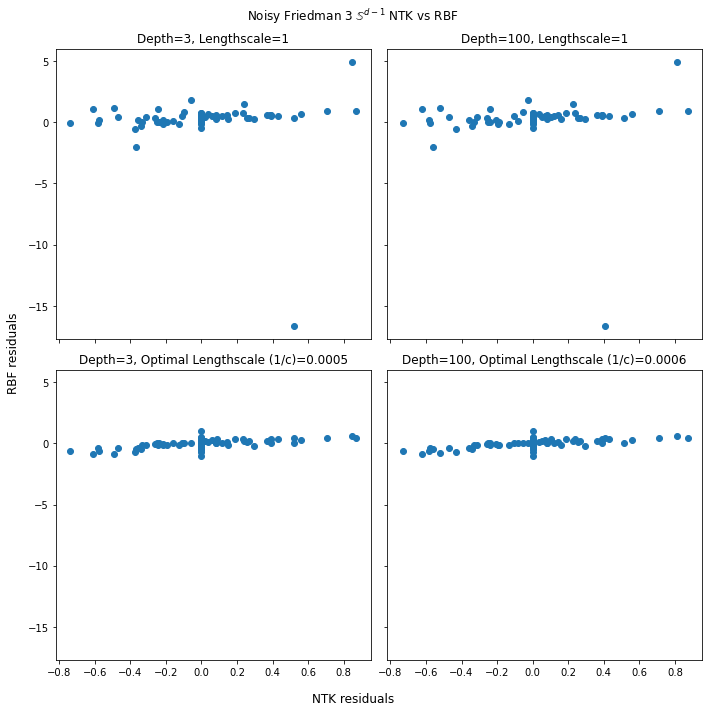

In [53]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_rbf)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_rbf)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noisy Friedman 3 $\mathbb{S}^{d-1}$ NTK vs RBF')
fig2.supxlabel('NTK residuals')
fig2.supylabel('RBF residuals')
fig2.tight_layout()

In [54]:
# lengthscale = np.linspace(0.1, 5, 50)

# fig, ax = plt.subplots(nrows=10, ncols=5, sharex=True, sharey=True, figsize=(15, 30))
# ax=ax.ravel()

# for x, ax in zip(lengthscale, ax):
#     rbf = (
#         ConstantKernel(
#             constant_value=0.05, 
#             constant_value_bounds=(1e-9, 1e5) 
#         ) * 
#         Matern(
#             nu=np.inf,
#             length_scale=x,
#             length_scale_bounds='fixed',#(1e-1, 1e3), 
#         ) 
#     )

#     gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
#     gp.fit(X_train_norm, y_train)
#     mean_rbf = gp.predict(X_norm)

#     ax.set_title(f'RBF Lengthscale={x.round(2)}')
#     ax.scatter(y-mean_ntk_1, y-mean_rbf)

# fig.suptitle(r"NTK vs RBF Kernel in $\mathbb{S}^{d-1}$")
# fig.supxlabel('NTK residuals')
# fig.supylabel('RBF residuals')
# fig.tight_layout()

In [55]:
# rbf = (
#     ConstantKernel(
#         constant_value=0.05, 
#         constant_value_bounds=(1e-9, 1e5) 
#     ) * 
#     Matern(
#         nu=np.inf,
#         length_scale=0.35,
#         length_scale_bounds=(1e-1, 1e3), 
#     ) 
# )

# gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
# gp.fit(X_train_norm, y_train)
# mean_rbf = gp.predict(X_norm)
# print(rbf)
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.set_title(f'RBF Lengthscale={0.35}')
# ax.scatter(y-mean_ntk_1, y-mean_rbf)

In [56]:
np.corrcoef((y-mean_ntk_1)[:,0], (y-mean_rbf)[:,0])

array([[ 1.        , -0.03053917],
       [-0.03053917,  1.        ]])

In [57]:
np.corrcoef((y-mean_ntk_1)[:,0], (y-mean_lpk)[:,0])

array([[1.        , 0.99999934],
       [0.99999934, 1.        ]])